In [105]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

##### Importing the Dataset as pandas dataframe

In [106]:
df = pd.read_csv('Data - Parkinsons')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


##### Shape of Dataset
* No of columns - 24
* No of rows - 195


In [107]:
df.shape

(195, 24)

* As per the below information, we can see that there is no direct null values in the dataset

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

* The scale of all the attributes are very different from each other. So we have to scale the attributes before proceeding with model building.

In [109]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MDVP:Fo(Hz),195.0,154.228641,41.390065,88.333000,117.572000,148.790000,182.769000,260.105000
MDVP:Fhi(Hz),195.0,197.104918,91.491548,102.145000,134.862500,175.829000,224.205500,592.030000
MDVP:Flo(Hz),195.0,116.324631,43.521413,65.476000,84.291000,104.315000,140.018500,239.170000
MDVP:Jitter(%),195.0,0.006220,0.004848,0.001680,0.003460,0.004940,0.007365,0.033160
MDVP:Jitter(Abs),195.0,0.000044,0.000035,0.000007,0.000020,0.000030,0.000060,0.000260
MDVP:RAP,195.0,0.003306,0.002968,0.000680,0.001660,0.002500,0.003835,0.021440
MDVP:PPQ,195.0,0.003446,0.002759,0.000920,0.001860,0.002690,0.003955,0.019580
Jitter:DDP,195.0,0.009920,0.008903,0.002040,0.004985,0.007490,0.011505,0.064330
MDVP:Shimmer,195.0,0.029709,0.018857,0.009540,0.016505,0.022970,0.037885,0.119080
MDVP:Shimmer(dB),195.0,0.282251,0.194877,0.085000,0.148500,0.221000,0.350000,1.302000


##### Distribution of Target column

* The target column is imbalanced as we have more dieseased people in dataset.

In [110]:
df.status = df.status.astype('category')
df.status.value_counts()

1    147
0     48
Name: status, dtype: int64

##### Challenges
* We could see that the size of sample is very small, so there many be more chances to over fit the data.
* The target column is not balanced which may affect the performance of the model.
* There are many input features. We have to perform EDA and select the most optimal features required for the model.

##### Correlation Matrix
* We can see that there is high corelation between many features in the dataset.

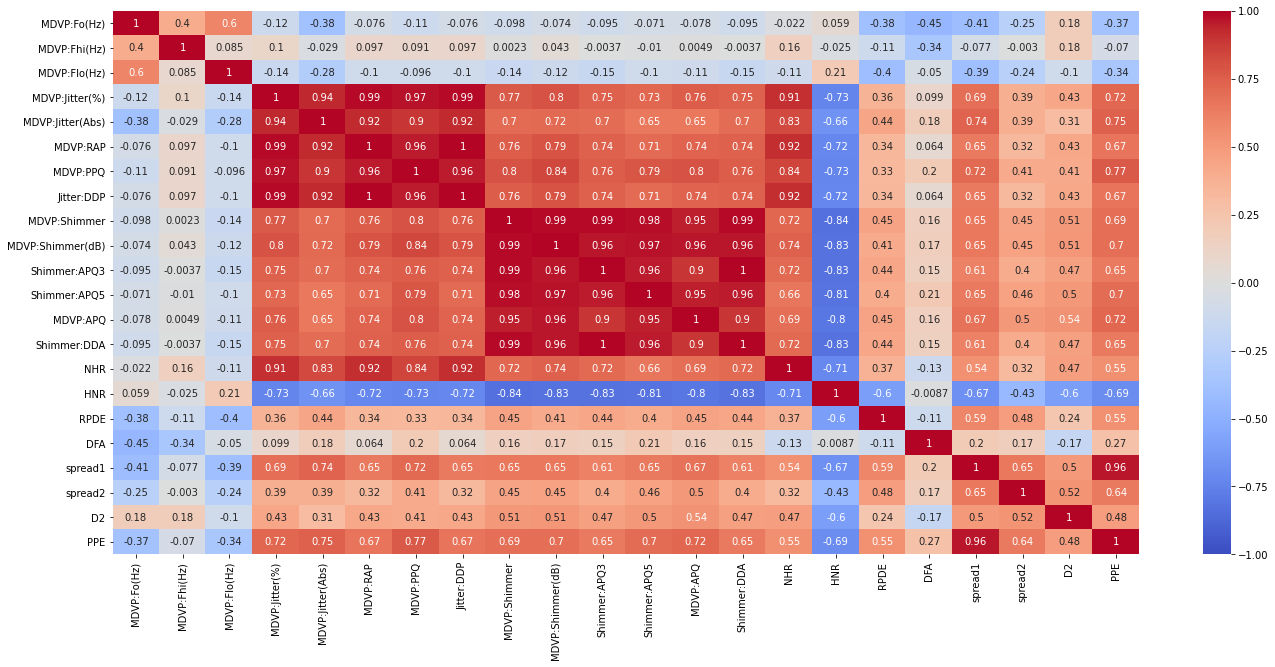

In [111]:
df.describe()
corr = df.drop(['name', 'status'], axis = 1).corr()
fig, ax = plt.subplots(figsize = [23,10])

sns.heatmap(corr, annot = True, vmin = -1, vmax = 1, center = 0, cmap="coolwarm")

##### Filtering Highly Correlated columns
* From plot we can see that attributes (MDVP:Jitter(%),	MDVP:Jitter(Abs),	MDVP:RAP,	MDVP:PPQ,	Jitter:DDP) are highly correlated to NHR.
* Also attributes (MDVP:Shimmer, MDVP:Shimmer(dB),	Shimmer:APQ3,	Shimmer:APQ5,	MDVP:APQ,	Shimmer:DDA) are highly correlated to HNR.
* Then Speard1 and PPE are highly correlated.
* So it is better to replace all these feature with 3 features NHR, HNR and PPE since adding highly correlated variables will not improve model performance but increase complexity. 

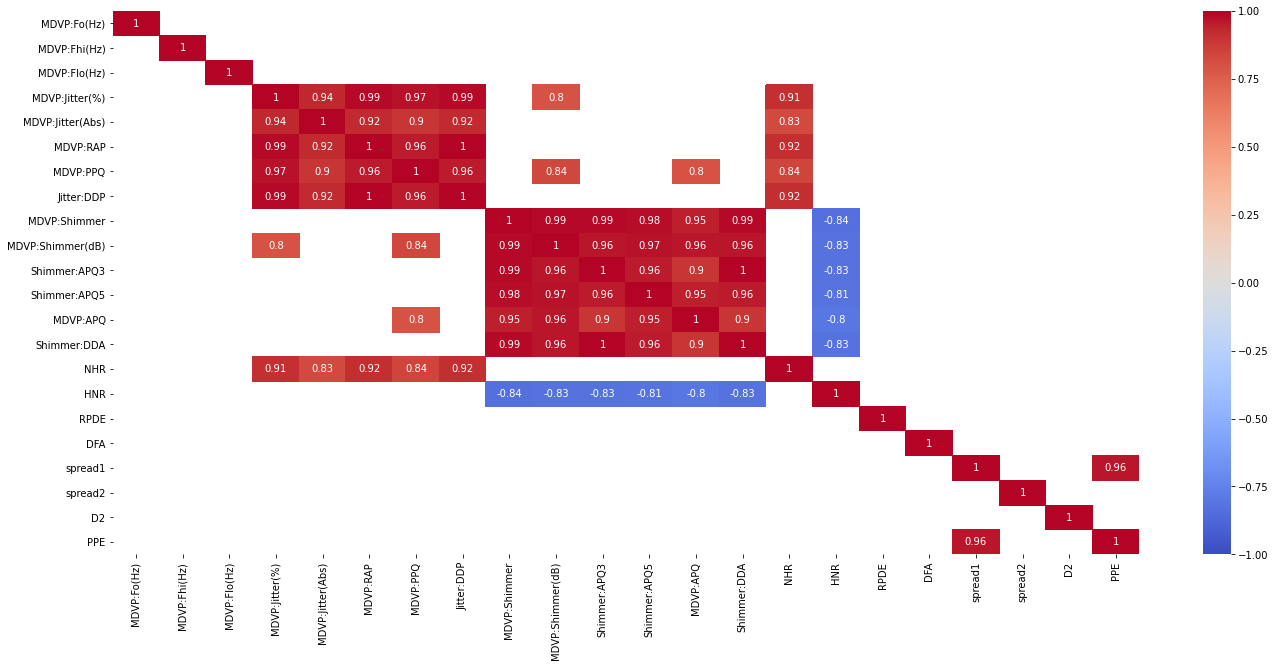

In [112]:
corr_pos = corr.abs()
mask = (corr_pos < 0.8 ) 
fig, ax = plt.subplots(figsize = [23,10])
sns.heatmap(corr, annot = True, vmin = -1, vmax = 1, center = 0, mask = mask, cmap="coolwarm")

##### Nature of distribution of features to be removed
* All the attributes which are correlated to NHR and HNR almost has very highly skewed on one side. 
* It do not follows normal distribution. So replacing the outliers with may affect the nature of distribution.
* PPE and spread1 are normally distributed, so the outliers can be treated here. 

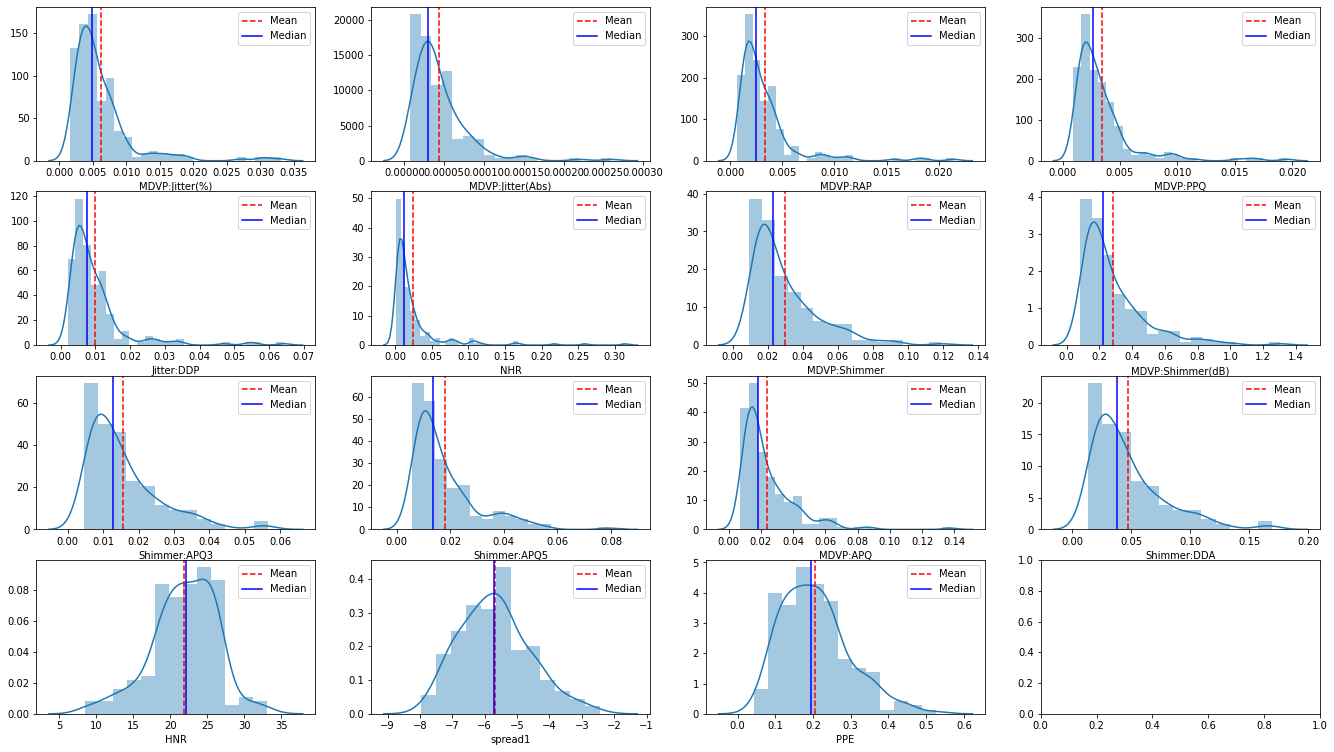

In [113]:
f = ['MDVP:Jitter(%)',	'MDVP:Jitter(Abs)',	'MDVP:RAP',	'MDVP:PPQ',	'Jitter:DDP', 'NHR', 
     'MDVP:Shimmer',	'MDVP:Shimmer(dB)',	'Shimmer:APQ3',	'Shimmer:APQ5',	'MDVP:APQ',	'Shimmer:DDA', 'HNR', 'spread1', 'PPE']
fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize = [23, 13])
for f, ax in zip(f, ax.flatten()):
  sns.distplot(df[f], ax =ax)
  mean = df[f].mean()
  median = df[f].median()
  ax.axvline(mean, color='r', linestyle='--')
  ax.axvline(median, color='b', linestyle='-')
  ax.legend({'Mean':mean, 'Median':median})


##### Distribution of selected features
* Distribution of attributes (MDVP:Fo(Hz), HNR, RPDE, DFA, spread2, D2, PPE) are fairly normal.
* Attributes (MDVP:Fhi(Hz), MDVP:Flo(Hz), NHR) are  right skewed.
* Removing the outliers of these highly skewed features may affect the nature of distribution.

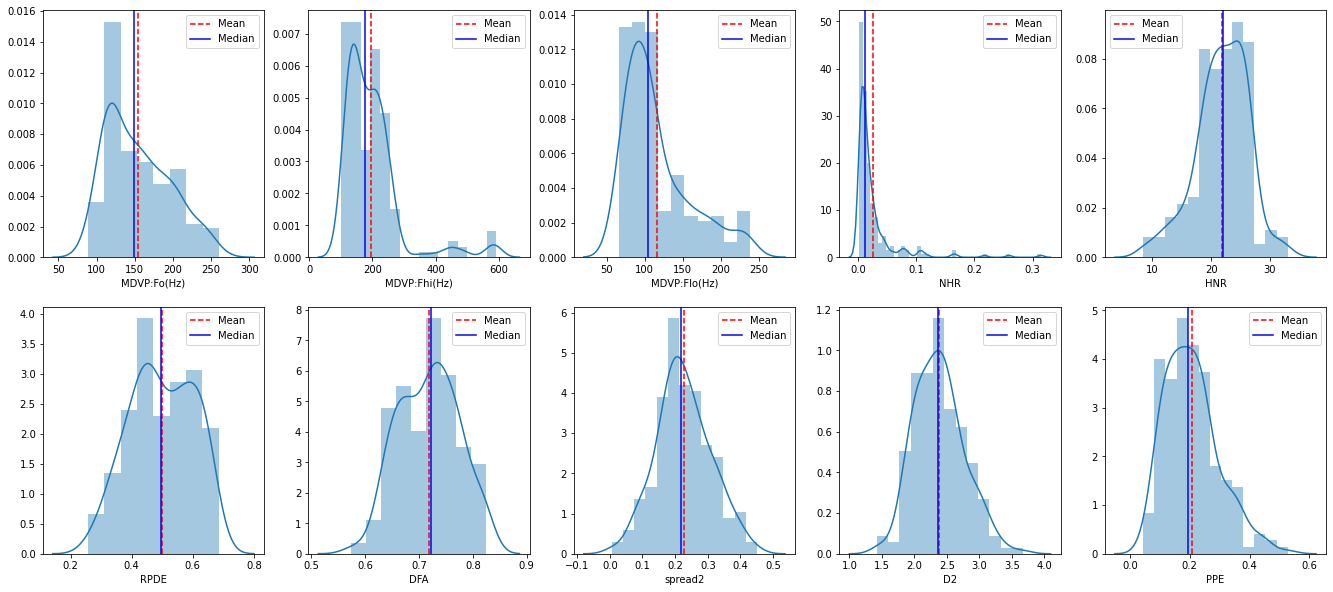

In [114]:
features = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'NHR', 'HNR', 'RPDE', 'DFA',  'spread2', 'D2', 'PPE']
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = [23, 10])
for feature, ax in zip(features, ax.flatten()):
  sns.distplot(df[feature], ax =ax)
  mean = df[feature].mean()
  median = df[feature].median()
  ax.axvline(mean, color='r', linestyle='--')
  ax.axvline(median, color='b', linestyle='-')
  ax.legend({'Mean':mean, 'Median':median})


##### Checking Outliers
* There are many outliers in positive side of MDVP:Fhi(Hz), MDVP:Flo(Hz), NHR columns. Treating these outliers may affect the nature of the distribution as it is not normally distributed.
* For all other attributes we can replace with 25th and 75th percentile for lower and higher outliers respectively.

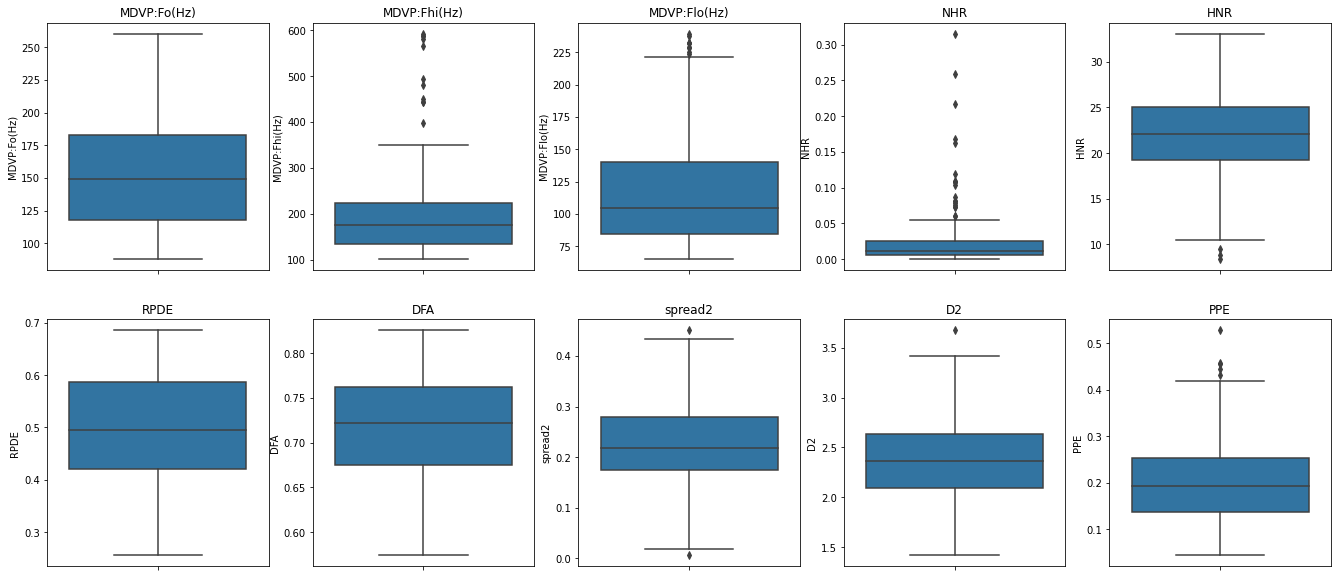

In [115]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = [23, 10])
for feature, ax in zip(features, ax.flatten()):
  sns.boxplot(df[feature], ax =ax, orient = 'v')
  ax.set_title(feature)


##### Distribution of independent features with respect to target column
* There is a non overlapping inter quartile range between 2 classes of target  for spread2 and PPE columns. So these features may have more weightage in prediction. 
* The outlier of MDVP:Fhi(Hz) and NHR is very high for diseased people which shows some unusuall values for diseased people. 
* Outliers of HNR  distributed in opposite direction between healthy and diseased people which may give some more information on classification.

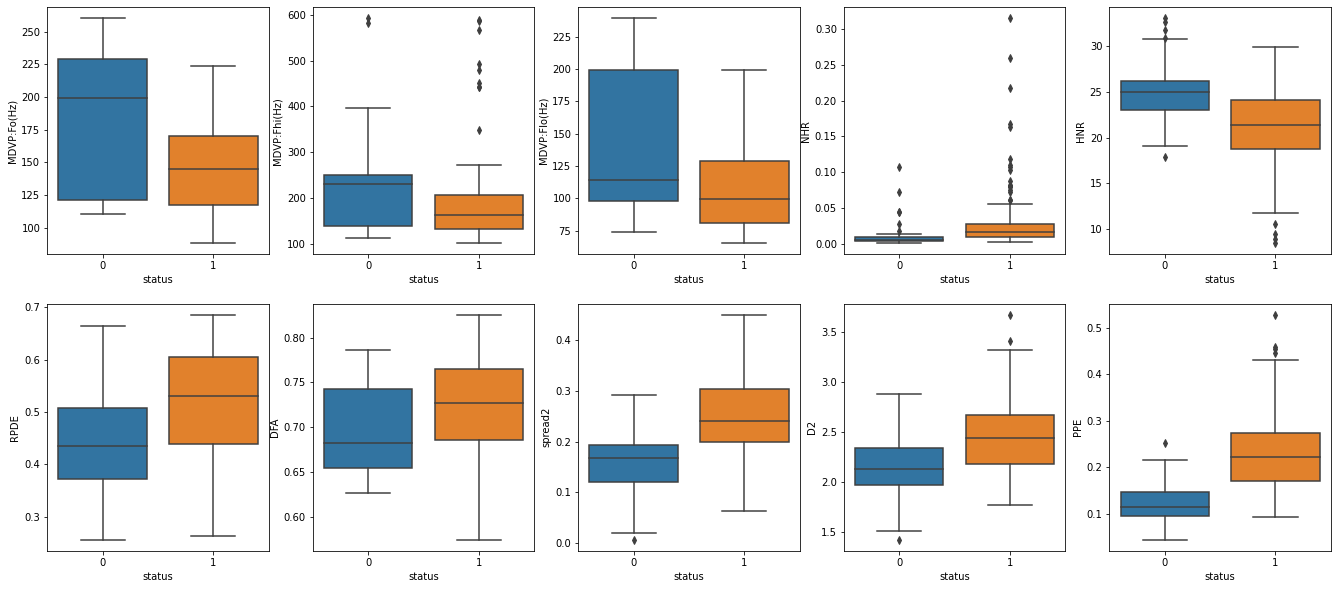

In [116]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = [23, 10])
for feature, ax in zip(features, ax.flatten()):
  sns.boxplot( x= 'status', y  = feature, data = df, ax =ax)

##### Checking with outliers of NHR
* We know that the attributes (MDVP:Jitter(%),	MDVP:Jitter(Abs),	MDVP:RAP,	MDVP:PPQ,	Jitter:DDP, NHR) are highly correlated to each other.
* Lets treat the outliers for NHR and one column MDVP:Jitter(%).
* On removing outliers we can see that the correlation between attributes is dropped.
* So removing outliers is affecting the nature of the information. 


In [117]:
p_NHR = np.percentile(df.NHR, [25,75])
p_Jitter = np.percentile(df['MDVP:Jitter(%)'], [25,75])
iqr_NHR = p_NHR[1] = p_NHR[0]
iqr_Jitter = p_Jitter[1] = p_Jitter[0]
corrected_NHR = df.NHR.clip(p_NHR[0]-1.5*iqr_NHR, p_NHR[1]+1.5*iqr_NHR)
corrected_Jitter = df['MDVP:Jitter(%)'].clip(p_Jitter[0]-1.5*iqr_Jitter, p_Jitter[1]+1.5*iqr_Jitter)
corr = np.corrcoef(corrected_Jitter,corrected_NHR)
corr

array([[1.       , 0.7369447],
       [0.7369447, 1.       ]])

##### Checking the outliers of HNR
* Similar to NHR even here removing the outliers of highly correlated columns decreasing the correlation.
* We are not removing the outliers of these columns.

In [118]:
p_HNR = np.percentile(df.HNR, [25,75])
p_Shimmer = np.percentile(df['MDVP:Shimmer'], [25,75])
iqr_HNR = p_HNR[1] = p_HNR[0]
iqr_Shimmer = p_Shimmer[1] = p_Shimmer[0]
corrected_HNR = df.NHR.clip(p_HNR[0]-1.5*iqr_HNR, p_HNR[1]+1.5*iqr_HNR)
corrected_Shimmer = df['MDVP:Shimmer'].clip(p_Shimmer[0]-1.5*iqr_Shimmer, p_Shimmer[1]+1.5*iqr_Shimmer)
corr = np.corrcoef(corrected_Shimmer,corrected_HNR)
corr

array([[1.        , 0.48860293],
       [0.48860293, 1.        ]])

#### Pipeline

* We are using Pipeline feature available in Scikit Learn to build our model.
* Pipelines helps to bulid a better readable organized model.
* It helps to process the train, test dataset seperately which refrains the model from data leakage.

---
#### Planned Steps:-

1. Preprocessing
>* Selection only these features and removing all highly correlated features. 
>*  (MDVP:Fo(Hz), MDVP:Fhi(Hz), MDVP:Flo(Hz), NHR, HNR, RPDE, DFA, spread2, D2, PPE)
>* Removing the outliers of (MDVP:Fo(Hz), RPDE, DFA, spread2, D2, PPE)


2. Scaling
>* Scaling all the input features.

3. ML Model
>* Fitting the date to machine Learning Algorithm.

In [119]:
#funection to treat outliers in the features
def outlier_correction(df):
  outlier_features = ['MDVP:Fo(Hz)', 'RPDE', 'DFA',  'spread2', 'D2', 'PPE']
  for col in outlier_features:
    p = np.percentile(df[col], [25, 75])
    iqr = p[1]-p[0]
    df.loc[:, col].clip(lower = p[0]-1.5*iqr, upper = p[1]+1.5*iqr, inplace = True)
  return df

In [120]:
#Removing all highly correlated features and selecting only these features
features = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'NHR', 'HNR', 'RPDE', 'DFA',  'spread2', 'D2', 'PPE']
#f = [ i for i in df.columns if i not in  ['name', 'status', 'spread1']]
column = ColumnTransformer( 
                              transformers = [('encoding', MinMaxScaler(), features)]
                      )
pipeline_model = Pipeline(
    [('outliers', FunctionTransformer(outlier_correction)),
     ('scaling', column),
     ('model', LogisticRegression())
     ]
)

In [121]:
seed = 4
#Seperating input and target features
x = df.drop('status', axis =1)
y = df['status']
#splitting into train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = seed)

In [122]:
#Creating many possible set of paramters for hyperparameter tuning for logistic regression
params_logistic = [ {
    'scaling__encoding' : [MinMaxScaler(), StandardScaler(), RobustScaler()],
    'model':[LogisticRegression()],
    'model__penalty' : ['l1', 'l2'],
    'model__solver' : ['liblinear'],
    'model__C' : np.logspace(0, 4, 10),
    'model__random_state' : [seed]
},
{
    'scaling__encoding' : [MinMaxScaler(), StandardScaler(), RobustScaler()],
    'model':[LogisticRegression()],
    'model__penalty' : ['l2'],
    'model__solver' : ['newton-cg', 'sag' , 'saga'  'ibfgs'],
    'model__C' : np.logspace(0, 4, 10),
    'model__random_state' : [seed]
},
{
    'scaling__encoding' : [MinMaxScaler(), StandardScaler(), RobustScaler()],
    'model':[LogisticRegression()],
    'model__penalty' : ['elasticnet'],
    'model__solver' : ['saga'],
    'model__C' : np.logspace(0, 4, 10),
    'model__random_state' : [seed]
}
]

In [123]:
#Creating many possible set of paramters for hyperparameter tuning for KNN
params_knn = {
    'scaling__encoding' : [MinMaxScaler(), StandardScaler(), RobustScaler()],
    'model': [KNeighborsClassifier()],
    'model__n_neighbors' : [i for i in range(5, 15, 2)],
    'model__leaf_size' : [i for i in range(3, 50, 5)],
    # As we saw some outliers helped in classification and also we havent removed that outliers.
    # Making the weight uniform make sure that model gives uniform weightage to outliers too.
    'model__weights' : ['uniform'] 
}

In [124]:
#Creating many possible set of paramters for hyperparameter tuning for SVM
params_svm = {
    'scaling__encoding' : [MinMaxScaler(), StandardScaler(), RobustScaler()],
    'model' : [SVC(probability = True)],
    'model__C': [i for i in range(1, 30, 1)],
    'model__kernel' : ['linear']
            }

In [125]:
#Creating a dictionary of the parameters of all models
params = {
          'Logistic Regression': params_logistic,
          'KNN': params_knn,
          'SVM': params_svm
          }
#Creating a array to store the best estimate
model =[]
#Creating DataFrame to store the performance metrics of each model.
performance = pd.DataFrame(columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Mean Cross Validation Accuracy',
                                   '+/- Deviation in Cross validation accuracy'])
#Iterating throught each model
for key in params:
  #Using StratifiedKFold to make sure that the both class of target is evenly distributed
  stf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
  gridSearch = GridSearchCV(pipeline_model, params[key], n_jobs= -1, cv = stf)
  gridSearch.fit(x_train, y_train)
  #Storing the tuple of best estimate of each model which can be fed as input to ensemble classifier.
  model.append((key, gridSearch.best_estimator_))
  cv = cross_val_score(gridSearch.best_estimator_, x, y, cv = stf)
  performance = performance.append({'Model': key, 
                            'Train Accuracy':  np.round(gridSearch.score(x_train, y_train)*100, decimals = 2),
                            'Test Accuracy': np.round(gridSearch.score(x_test, y_test)*100, decimals = 2),
                            'Mean Cross Validation Accuracy': np.round(cv.mean()*100, decimals = 2),
                            '+/- Deviation in Cross validation accuracy': np.round(cv.std()*2*100, decimals = 2)}, ignore_index = True) 

##### Observations

* Here we could see that all the models performed well in both training and test data but there is a high variation in cross validation.
* The range of accuracy is widely spread in cross validation, so there is a chances of getting least accuracy in this range for new data. 
* Dataset size is very small and also the target column is not equally distributed.
* So a single model may not perform well.  

In [126]:
performance

,Model,Train Accuracy,Test Accuracy,Mean Cross Validation Accuracy,+/- Deviation in Cross validation accuracy
0,Logistic Regression,87.50,88.14,84.10,9.94
1,KNN,93.38,89.83,91.28,4.10
2,SVM,87.50,93.22,88.72,5.23


##### Meta Classifier
* As we saw there may be huge variation in output if use a single model to predict the output.
* So here we are combining the output of all the 3 models and predicting the final output from the 3 models using another model called as Meta Classifier.
* We are using logistic regression as a Meta classifier here.
* We could see that mean accuracy and deviation of accuracy in cross validation is much better than all the models individually.
* So collectively these models provided a better performance. 

In [127]:
#giving all the best estimators in list of tuples
#It chooses Logistic Regression as a metaclassifier
sk = StackingClassifier( estimators = model)
sk.fit(x_train, y_train)
cv_sk = cross_val_score(sk, x, y, cv = stf)
performance = performance.append({'Model': 'StackingClassifier', 
                            'Train Accuracy':  np.round(sk.score(x_train, y_train)*100, decimals = 2),
                            'Test Accuracy': np.round(sk.score(x_test, y_test)*100, decimals = 2),
                            'Mean Cross Validation Accuracy': np.round(cv_sk.mean()*100, decimals = 2),
                            '+/- Deviation in Cross validation accuracy': np.round(cv_sk.std()*2*100, decimals = 2)}, ignore_index = True) 
performance

,Model,Train Accuracy,Test Accuracy,Mean Cross Validation Accuracy,+/- Deviation in Cross validation accuracy
0,Logistic Regression,87.50,88.14,84.10,9.94
1,KNN,93.38,89.83,91.28,4.10
2,SVM,87.50,93.22,88.72,5.23
3,StackingClassifier,97.06,89.83,91.79,3.84


In [128]:
params_ramdomforest = {
    'model': [RandomForestClassifier(n_estimators = 300,  ccp_alpha = 0.02,
                                     max_features = 0.4,  random_state = seed)],
    'model__criterion': ['gini', 'entropy']
}
ramdomforest = GridSearchCV(pipeline_model, params_ramdomforest, n_jobs= -1)
ramdomforest.fit(x_train, y_train)
cv_ramdomforest = cross_val_score(ramdomforest.best_estimator_, x, y, cv = stf)
performance = performance.append({'Model': 'Random Forest', 
                          'Train Accuracy':  np.round(ramdomforest.score(x_train, y_train)*100, decimals = 2),
                          'Test Accuracy': np.round(ramdomforest.score(x_test, y_test)*100, decimals = 2),
                          'Mean Cross Validation Accuracy': np.round(cv_ramdomforest.mean()*100, decimals = 2),
                          '+/- Deviation in Cross validation accuracy': np.round(cv_ramdomforest.std()*2*100, decimals = 2)}, ignore_index = True) 

In [129]:
params_xgboost = {
    'model': [XGBClassifier(random_state= seed)],
    'model__booster': ['gbtree', 'gblinear'],
    'model__gamma': [ 1.5, 2, 3, 4],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__max_depth': [3, 4, 5]
}
xgboost = GridSearchCV(pipeline_model, params_xgboost, n_jobs= -1)
xgboost.fit(x_train, y_train)
cr_xgboost = cross_val_score(xgboost.best_estimator_, x, y, cv = stf)
performance = performance.append({'Model': 'XGBoost', 
                          'Train Accuracy':  np.round(xgboost.score(x_train, y_train)*100, decimals = 2),
                          'Test Accuracy': np.round(xgboost.score(x_test, y_test)*100, decimals = 2),
                          'Mean Cross Validation Accuracy': np.round(cr_xgboost.mean()*100, decimals = 2),
                          '+/- Deviation in Cross validation accuracy': np.round(cr_xgboost.std()*2*100, decimals = 2)}, ignore_index = True) 

##### Boosting and Bagging Classifiers
* Random Forest and XGBoost are powerfull Bagging and Boosting Classifiers respectively.
* These models produce many weak learners and combine the output of these weak learners to give a best result. 
* We can see that both the models provided best train, test accuracy and also provided best performance in cross validation. 

In [130]:
performance

,Model,Train Accuracy,Test Accuracy,Mean Cross Validation Accuracy,+/- Deviation in Cross validation accuracy
0,Logistic Regression,87.50,88.14,84.10,9.94
1,KNN,93.38,89.83,91.28,4.10
2,SVM,87.50,93.22,88.72,5.23
3,StackingClassifier,97.06,89.83,91.79,3.84
4,Random Forest,100.00,96.61,92.31,3.24
5,XGBoost,99.26,96.61,92.31,4.59


##### Choosing Best model

* From above result we could see that both Random Forest and XGBoost gave best output than anyother models.
* The variation in accuracy is least of all for Random Forest.
* Being very narrow in deviation of accuracy, Random Forest is most stable model here.
* So can pickup Random Forest as best model. 